### 1. Loading Required Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.ndimage import gaussian_filter1d
from scipy.stats import skew, kurtosis
from scipy.fft import fft
from scipy.integrate import simpson
from skimage.measure import find_contours
from scipy.ndimage import map_coordinates, gaussian_filter

### 2. Loading Images, Masks and visualizing

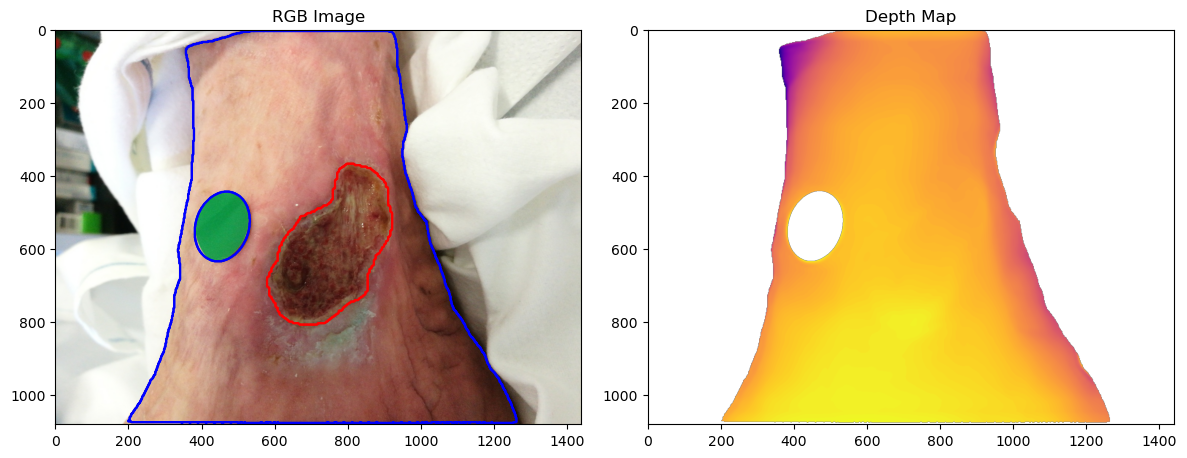

In [6]:
#sample file name
#name = '-Lc_d-g4yyU44NLZYjLv.-Lc_dR6iUjsYfyL3NJc5.-Lc_dxMn-GvgO7lEfgfE'
#name = '-LcfARU6yMZ2m2s6CoLf.-LhiLyo332AVoAFcUndg.-LoU0rVOOmA1bDIx3zLF'
#name = '-LeGr5GgY30JbjHXHI69.-LeGrASzOiaSf8oHM-pF.-LeGrt6CF6EZBfcZFwqY'
name = '-Leujocx_cjh-Ci6MrBu.-NLUo7sNx6hp4uSLWSwI.-NQ-6HHv1xoKIDy48blM'
#name = '-LzGpa0VPSMJr2F9rDCN.-LzGpeFMtDMDIZw91eP3.-MIYUwBw1GSWCJ3DThGw'
#name = '-LiMpCaA24H9MjEXOVk0.-LiMpKyjdotKO7FGl0BA.-LiMymF5piukCb3-bLxl'

#file path
base_path = "../../data"

#loading files
img = cv2.imread(f"{base_path}/images/{name}.png")[..., ::-1] #BGR to RGB
depth = cv2.imread(f"{base_path}/depth_maps/{name}.png", cv2.IMREAD_ANYDEPTH) # IMREAD_ANYDEPTH to read 16-bit depth images
wound = cv2.imread(f"{base_path}/wound_masks/{name}.png", cv2.IMREAD_GRAYSCALE) #define wound mask (white = wound, black = not wound)
body = cv2.imread(f"{base_path}/body_masks/{name}.png", cv2.IMREAD_GRAYSCALE) # define body mask (white = body)
marker = cv2.imread(f"{base_path}/marker_masks/{name}.png", cv2.IMREAD_GRAYSCALE) # define marker mask (like rular or color patch)

# Apply body mask and remove marker
depth = cv2.bitwise_and(depth, depth, mask=body)
if marker is not None:
    depth = cv2.bitwise_and(depth, depth, mask=~marker)
    body = cv2.bitwise_and(body, body, mask=~marker)

# Visualizing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.imshow(img)
ax1.set_title("RGB Image")
ax1.contour(wound, levels=1, colors='red')
ax1.contour(body, levels=1, colors='blue')

#display depth map
ax2.imshow(np.where(depth != 0, depth, np.nan), cmap='plasma_r')
ax2.set_title("Depth Map")
plt.tight_layout()
plt.show()

### 3. Filtering Depth Outliers (Using Z score)

Text(0.5, 1.0, 'Filtered Depth (Z-Score)')

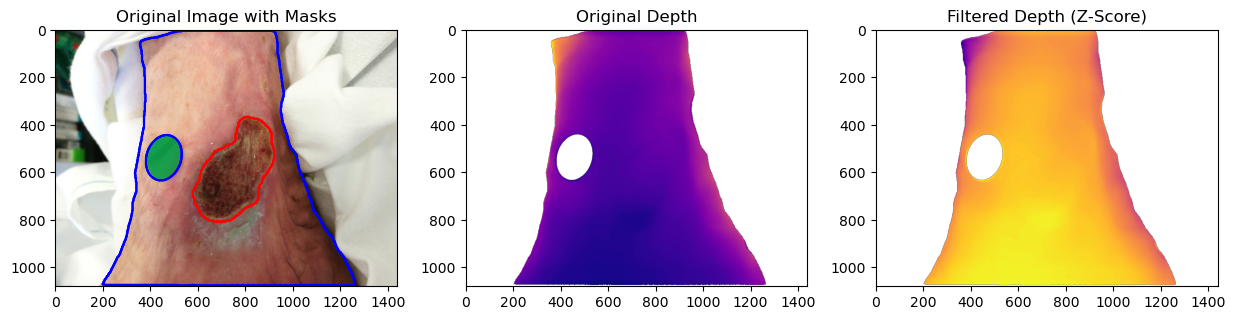

In [7]:
# Compute Z-score for each pixel in the depth map
z_score = (depth - depth.mean()) / depth.std()  

# Create a copy of the body mask to modify
body_corrected = body.copy()

# Remove outliers: keep only pixels with |Z| < 2
body_corrected[(z_score < -2) | (z_score > 2)] = 0

# Apply the corrected body mask to the depth map
depth_component = cv2.bitwise_and(depth, depth, mask=body_corrected)

# Visualize the result: original image, original depth, filtered depth
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Displaing RGB image with corrected body mask
ax1.imshow(img)
ax1.set_title("Original Image with Masks")
ax1.contour(wound, levels=1, colors='red')          
ax1.contour(body_corrected, levels=1, colors='blue')

# Displaying raw depth map
ax2.imshow(np.where(depth != 0, depth, np.nan), cmap='plasma')
ax2.set_title("Original Depth")

# Show depth map after removing outliers
ax3.imshow(np.where(depth_component != 0, depth_component, np.nan), cmap='plasma_r')
ax3.set_title("Filtered Depth (Z-Score)")

### 4. Fit Body Surface and Correct Depth (Curvature Removal)

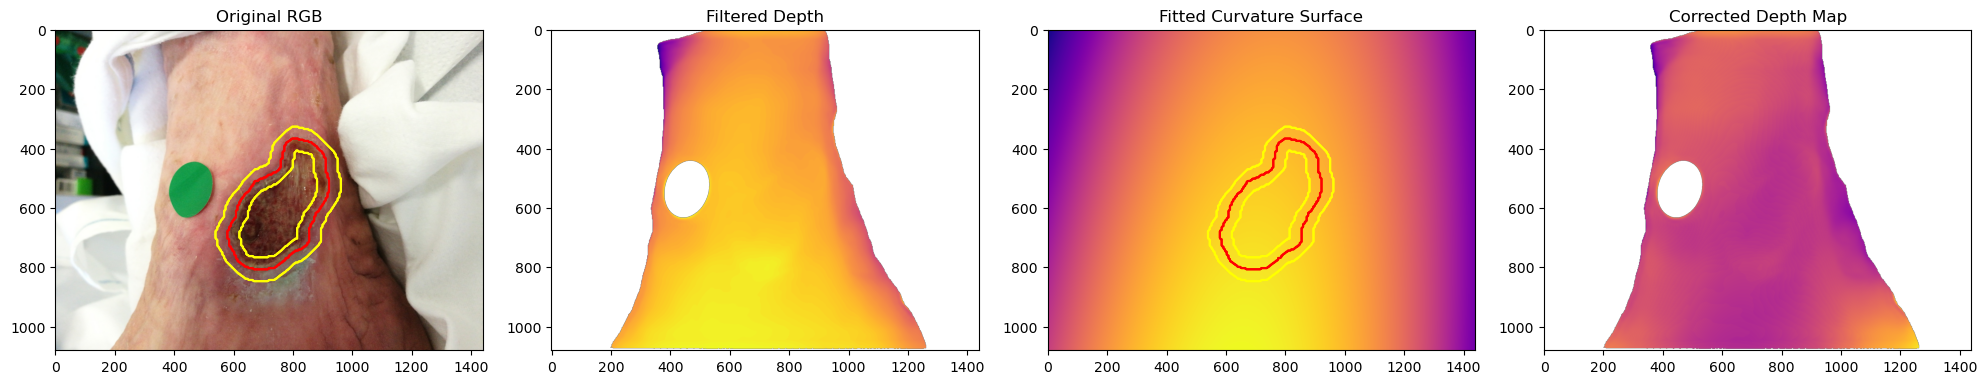

In [8]:
'''
Depth Correction Using Peri-lesion Mask for Curvature Fitting
Generate a symmetric ring (peri-lesion mask) around the wound and fit a 2D surface over that region.'''

# Define a quadratic surface model
def quad_surface(xy, a, b, c, d, e, f):
    x, y = xy
    return a + b*x + c*y + d*x**2 + e*y**2 + f*x*y

# Create peri-lesion mask: a ring ±margin pixels from the wound border
margin = 40 # How many pixels inside/outside the wound border to include
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))

# Dilate and erode the wound
wound_dilated = cv2.dilate(wound, kernel, iterations=margin)
wound_eroded = cv2.erode(wound, kernel, iterations=margin)

# XOR to create the symmetric ring around wound
peri_lesion_mask = cv2.bitwise_xor(wound_dilated, wound_eroded)

# Restrict to the body region only
peri_lesion_mask = cv2.bitwise_and(peri_lesion_mask, peri_lesion_mask, mask=body_corrected)

# Extract coordinates and depth values from the peri-lesion mask
coords_y, coords_x = np.where(peri_lesion_mask > 0)
z_vals = depth_component[coords_y, coords_x]

# Fit the quadratic surface to the peri-lesion region
params, _ = curve_fit(quad_surface, (coords_x, coords_y), z_vals)

# Evaluate the surface over the entire image grid
h, w = depth.shape
grid_y, grid_x = np.mgrid[0:h, 0:w]
fitted_surface = quad_surface((grid_x, grid_y), *params)

# Subtract fitted curvature to flatten depth map
depth_corrected = depth_component.astype(np.float32) - fitted_surface
depth_corrected[body == 0] = 0  # zero out non-body regions

# Plot result with debug visuals
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

ax1.imshow(img)
ax1.set_title("Original RGB")
ax1.contour(wound, levels=1, colors='red')
ax1.contour(peri_lesion_mask, levels=1, colors='yellow')

ax2.imshow(np.where(depth_component != 0, depth_component, np.nan), cmap='plasma_r')
ax2.set_title("Filtered Depth")

ax3.imshow(fitted_surface, cmap='plasma_r')
ax3.set_title("Fitted Curvature Surface")
ax3.contour(wound, levels=1, colors='red')
ax3.contour(peri_lesion_mask, levels=1, colors='yellow')

ax4.imshow(np.where(depth_corrected != 0, depth_corrected, np.nan), cmap='plasma_r')
ax4.set_title("Corrected Depth Map")

plt.tight_layout()
plt.show()

### 5. Wound Border Rectification and Unrolling Border Strip

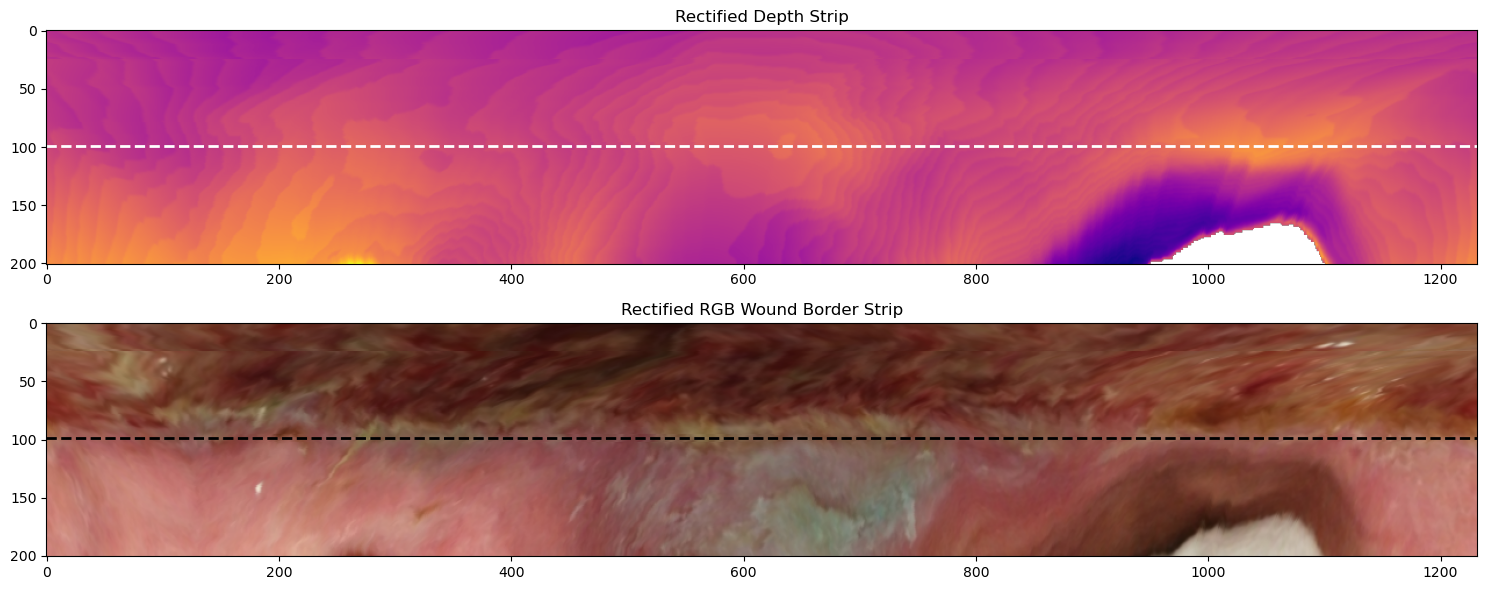

In [ ]:
def get_pixel_boundaries(img: np.ndarray, mask: np.ndarray) -> np.ndarray:
    '''
    Extract pixels belonging to mask edges
    '''
    cnt, _ = cv2.findContours(image=mask, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
    cnt = max(cnt, key=len)  # take largest contour
    cnt = np.squeeze(cnt)   # reshaping
    pixels = np.swapaxes(img, axis1=0, axis2=1) #
    pixels = pixels[tuple(cnt.T)] # get pixels at contour points
    pixels = np.expand_dims(pixels, axis=1) # add channel dimension
    return pixels

def rectify_boundary_mask(img: np.ndarray, mask: np.ndarray, iterations: int = 100):
    '''
    Perform rectification by stacking concentric erosions and dilations around wound mask.
    '''
    pxl1 = get_pixel_boundaries(img, mask)
    h, w, *_ = pxl1.shape
    dilations = [pxl1]

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    temp = mask.copy()
    Ndilation = 1

    for i in range(iterations):
        temp = cv2.dilate(temp, kernel, iterations=1)
        pxl = get_pixel_boundaries(img, temp)
        pxl = cv2.resize(pxl, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
        dilations.append(pxl)
    Ndilation = i

    temp = mask.copy()
    erosions = []
    Nerosion = 1

    for i in range(iterations):
        temp = cv2.erode(temp, kernel, iterations=1)
        ncomp, _ = cv2.connectedComponents(temp)
        if ncomp > 2:
            break
        pxl = get_pixel_boundaries(img, temp)
        pxl = cv2.resize(pxl, dsize=(w, h), interpolation=cv2.INTER_CUBIC)
        erosions.append(pxl)
    Nerosion = i

    rectify_img = np.hstack(erosions[::-1] + dilations)
    return rectify_img, (Ndilation, Nerosion)

# Blur input images
blurred_rgb = cv2.GaussianBlur(img, (5, 5), sigmaX=1)
blurred_depth = cv2.GaussianBlur(depth_corrected.astype(np.float32), (5, 5), sigmaX=1)

# Rectify the boundary mask
iterations = 100
rectify_depth, (s1, s2) = rectify_boundary_mask(
    np.where(blurred_depth != 0, blurred_depth, np.nan), 
    wound, 
    iterations=iterations
)
rectify_depth = rectify_depth.transpose(1, 0)

rectify_img, _ = rectify_boundary_mask(
    blurred_rgb, 
    wound, 
    iterations=iterations
)
rectify_img = rectify_img.transpose(1, 0, 2)

# Visualization generated rectified depth and RGB images
fig, ((ax1), (ax2)) = plt.subplots(nrows=2, ncols=1, figsize=(20, 6))
ax1.imshow(rectify_depth, cmap='plasma_r')
ax1.axhline(s1, linestyle='dashed', color='w', linewidth=2)
ax1.set_title("Rectified Depth Strip")

ax2.imshow(rectify_img)
ax2.axhline(s1, linestyle='dashed', color='k', linewidth=2)
ax2.set_title("Rectified RGB Wound Border Strip")

plt.tight_layout()
plt.show()

#### Alternate method

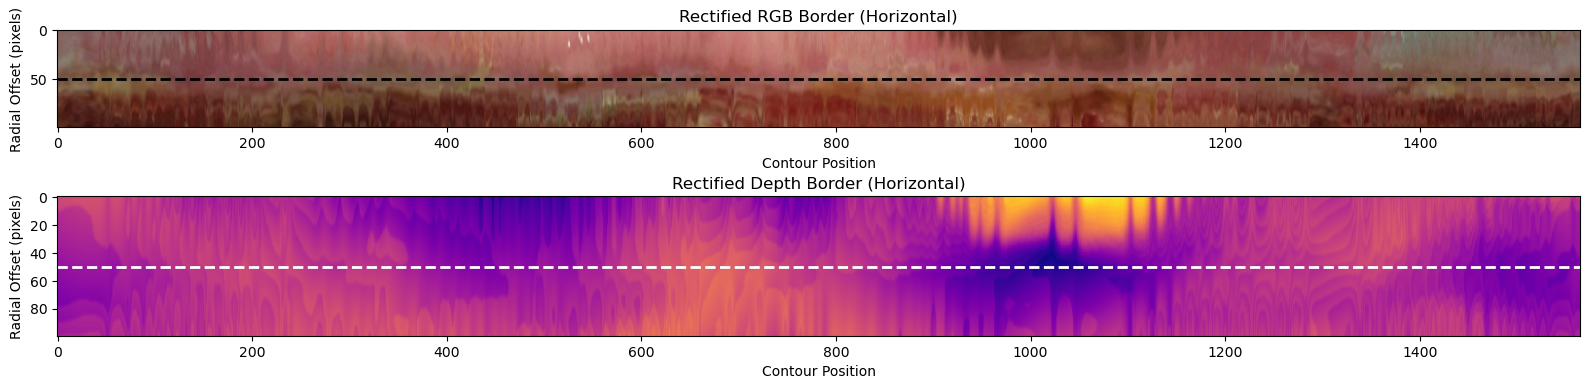

In [14]:
from skimage.measure import find_contours
from scipy.ndimage import map_coordinates, gaussian_filter

def rectify_boundary_mask(image, mask, iterations=100, num_samples=2000, normal_smooth_sigma=2):
    """
    Generate a rectified (unwrapped) border strip from an image around a wound mask.
    
    Args:
        image: 2D (depth) or 3D (RGB) image
        mask: binary wound mask
        iterations: total layers to sample perpendicular to wound (even number)
        num_samples: how many points to sample along the wound edge
        normal_smooth_sigma: smoothing of normals for cleaner sampling
    
    Returns:
        strip: rectified (rotated) image where Y=contour, X=radial offset
        (n_in, n_out): number of inward and outward sampling steps
    """
    assert iterations % 2 == 0, "iterations must be even"
    n_in = n_out = iterations // 2
    H, W = mask.shape

    # Extract largest contour
    contours = find_contours(mask, 0.5)
    if len(contours) == 0:
        raise ValueError("No contour found in mask.")
    contour = max(contours, key=lambda x: x.shape[0])
    contour = contour[::len(contour)//num_samples]  # uniformly sample

    # Compute smoothed outward normals
    dx = np.gradient(contour[:, 1])
    dy = np.gradient(contour[:, 0])
    norms = np.sqrt(dx**2 + dy**2) + 1e-8
    nx = gaussian_filter(dy / norms, sigma=normal_smooth_sigma)
    ny = gaussian_filter(-dx / norms, sigma=normal_smooth_sigma)

    # Sample image along normals to build strip
    layers = []
    for i in range(-n_in, n_out):
        offset_x = contour[:, 1] + i * nx
        offset_y = contour[:, 0] + i * ny

        if image.ndim == 2:
            row = map_coordinates(image, [offset_y, offset_x], order=1, mode='reflect')
        else:
            row = np.stack([
                map_coordinates(image[..., c], [offset_y, offset_x], order=1, mode='reflect')
                for c in range(3)
            ], axis=-1)
        layers.append(row)

    strip = np.array(layers)  # (layers, samples, [3])
    strip = strip.transpose(1, 0, 2) if image.ndim == 3 else strip.T  # Y=contour, X=radial
    return strip, (n_in, n_out)

# --- Step 1: Blur input images to reduce noise ---
blurred_rgb = cv2.GaussianBlur(img, (5, 5), sigmaX=1)
blurred_depth = cv2.GaussianBlur(depth_corrected.astype(np.float32), (5, 5), sigmaX=1)

# --- Step 2: Rectify RGB and depth ---
depth_input = np.where(blurred_depth != 0, blurred_depth, np.nan)
rectify_depth, (s1, s2) = rectify_boundary_mask(depth_input, wound, iterations=100, num_samples=800)
rectify_rgb, _ = rectify_boundary_mask(blurred_rgb, wound, iterations=100, num_samples=800)

# --- Step 3: Match shapes if needed ---
min_h = min(rectify_rgb.shape[0], rectify_depth.shape[0])
min_w = min(rectify_rgb.shape[1], rectify_depth.shape[1])
rectify_rgb = rectify_rgb[:min_h, :min_w]
rectify_depth = rectify_depth[:min_h, :min_w]


# Rotate both strips 90° counterclockwise for horizontal layout
rectify_rgb = np.rot90(rectify_rgb, k=1)
rectify_depth = np.rot90(rectify_depth, k=1)

# --- Visualization: Horizontal strips with correct dashed line ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 4))

# RGB Strip
ax1.imshow(rectify_rgb.astype(np.uint8))
ax1.axhline(s1, color='black', linestyle='--', linewidth=2)  # FIXED here
ax1.set_title("Rectified RGB Border (Horizontal)")
ax1.set_ylabel("Radial Offset (pixels)")
ax1.set_xlabel("Contour Position")

# Depth Strip
im = ax2.imshow(rectify_depth, cmap='plasma', aspect='auto')
ax2.axhline(s1, color='white', linestyle='--', linewidth=2)  # FIXED here
ax2.set_title("Rectified Depth Border (Horizontal)")
ax2.set_ylabel("Radial Offset (pixels)")
ax2.set_xlabel("Contour Position")
#fig.colorbar(im, ax=ax2, label="Depth")

plt.tight_layout()
plt.show()

### 6. Mean Depth Profile Extraction

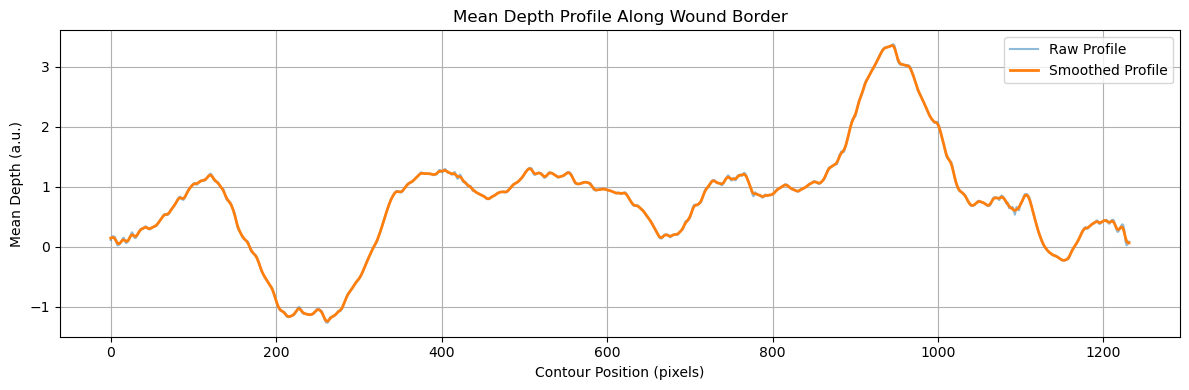

In [ ]:
# Make sure rectify_depth is the original (non-rotated) strip:
# shape = (radial offset, contour position)

# Compute mean depth along radial direction
# Ignore NaNs if any (use nanmean)
mean_profile = np.nanmean(rectify_depth, axis=0)

# Smooth the profile for better clarity
mean_profile_smooth = gaussian_filter1d(mean_profile, sigma=2)

# Visualize the raw and smoothed profiles
plt.figure(figsize=(12, 4))
plt.plot(mean_profile, label='Raw Profile', alpha=0.5)
plt.plot(mean_profile_smooth, label='Smoothed Profile', linewidth=2)
plt.title("Mean Depth Profile Along Wound Border")
plt.xlabel("Contour Position (pixels)")
plt.ylabel("Mean Depth (a.u.)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 6_1. 3D Wound Depth Landscape

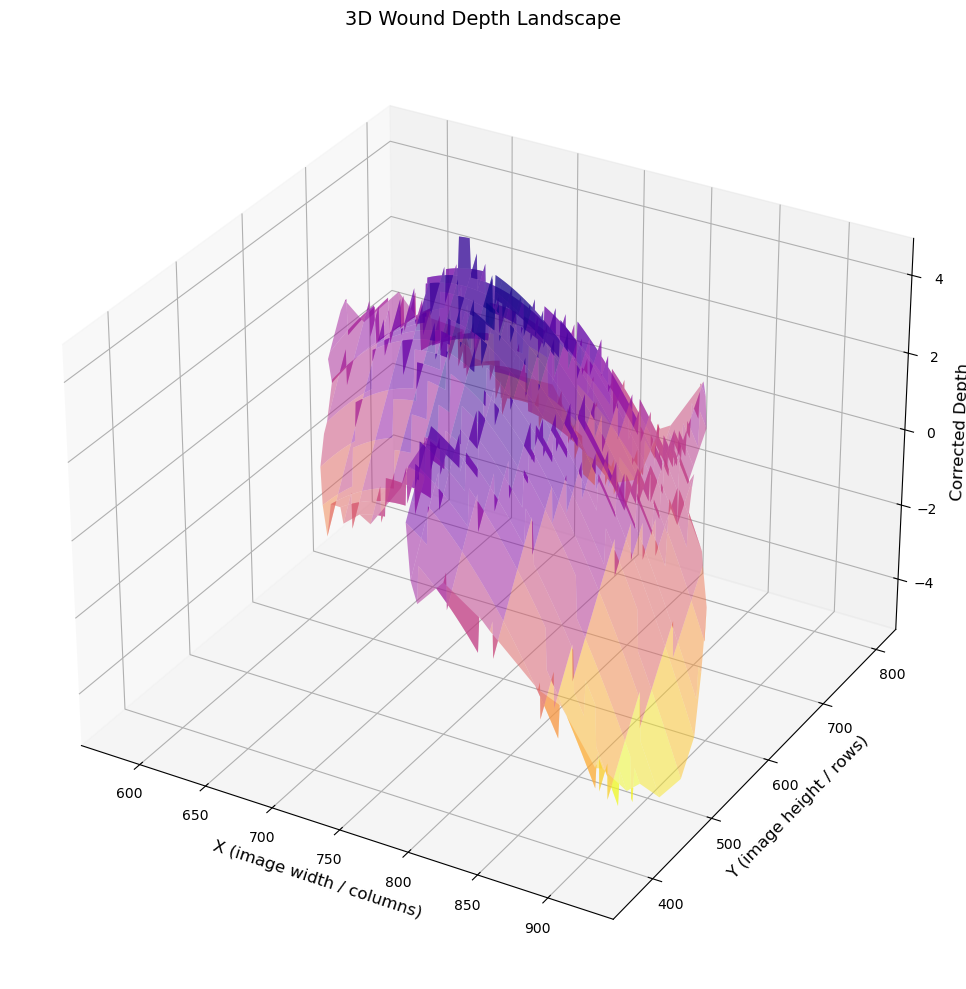

In [11]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# --- Create 3D figure ---
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# --- Get image shape ---
h, w = depth_corrected.shape

# --- Generate coordinate grids (X = cols, Y = rows) ---
X, Y = np.meshgrid(np.arange(w), np.arange(h))

# --- Mask X, Y, and Z to include only wound area ---
X_masked = np.where(wound != 0, X, np.nan)
Y_masked = np.where(wound != 0, Y, np.nan)
Z = np.where(wound != 0, depth_corrected, np.nan)

# --- Plot 3D surface ---
surf = ax.plot_surface(
    X_masked, Y_masked, Z,
    cmap='plasma_r', alpha=0.5, edgecolor='none'
)

# --- Add axis labels and title ---
ax.set_title("3D Wound Depth Landscape", fontsize=14)
ax.set_xlabel("X (image width / columns)", fontsize=12)
ax.set_ylabel("Y (image height / rows)", fontsize=12)
ax.set_zlabel("Corrected Depth", fontsize=12)

# --- Final layout ---
plt.tight_layout()
plt.show()

### 7. Feature Extraction from Mean Depth Profile

In [12]:
# -- Basic Statistical Features --
mean_val = np.mean(mean_profile_smooth)         # average depth
std_val = np.std(mean_profile_smooth)           # variation
min_val = np.min(mean_profile_smooth)           # shallowest point
max_val = np.max(mean_profile_smooth)           # deepest point
range_val = max_val - min_val                   # total range
skewness = skew(mean_profile_smooth)            # asymmetry in depth distribution
kurt = kurtosis(mean_profile_smooth)            # peakiness of the profile

# -- Shape Features --
slope = np.gradient(mean_profile_smooth)        # slope at each point
max_slope = np.max(np.abs(slope))               # steepest slope

# Center of mass: weighted average position (like centroid)
positions = np.arange(len(mean_profile_smooth))
center_of_mass = np.sum(positions * mean_profile_smooth) / np.sum(mean_profile_smooth)

# Area under the profile using Simpson's rule
area = simpson(mean_profile_smooth)

# --- Frequency Features (FFT) ---
# Compute first 10 absolute FFT magnitudes (excluding the 0th)
fft_vals = np.abs(fft(mean_profile_smooth))
fft_features = fft_vals[1:11]  # take 10 components after DC

# --- Combine All Features into One Vector ---
feature_vector = [
    mean_val,
    std_val,
    min_val,
    max_val,
    range_val,
    skewness,
    kurt,
    max_slope,
    center_of_mass,
    area
] + list(fft_features)

# create a feature names list for tracking
feature_names = [
    "mean", "std", "min", "max", "range", "skewness", "kurtosis",
    "max_slope", "center_of_mass", "area"
] + [f"fft_{i}" for i in range(1, 11)]

# Display features
for name, val in zip(feature_names, feature_vector):
    print(f"{name}: {val:.4f}")

mean: 0.7648
std: 0.9056
min: -1.2402
max: 3.3575
range: 4.5978
skewness: 0.2960
kurtosis: 1.1414
max_slope: 0.0583
center_of_mass: 770.6155
area: 942.0690
fft_1: 469.7213
fft_2: 243.7397
fft_3: 415.8862
fft_4: 256.3013
fft_5: 88.0890
fft_6: 254.8268
fft_7: 73.2116
fft_8: 71.2381
fft_9: 81.7832
fft_10: 75.3556
